In [7]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadSAR"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_azmith_resp import RangeAzimuthProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.plotting.movies_mmWave_data import MovieGeneratorMmWaveData


In [8]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR.cfg")
# cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)
print(cfg_manager.vel_res_m_s)
print(cfg_manager.vel_max_m_s)

0.009851742270887007
0.9851742270887008


In [9]:
#load the dataset
dataset_name = "CPSL_ENDFIRE_SAR_TEST_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel"
)

found 296 radar samples
found 296 lidar samples
did not find camera samples
did not find imu (orientation) samples
found 296imu (full data) samples
found 296 vehicle velocity samples


In [10]:
#load the plotter
plotter = PlotterMmWaveData(config_manager=cfg_manager)

#initialize a range azimuth processor
range_az_processor = RangeAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#initialize the range doppler processor
range_doppler_processor = RangeDopplerProcessor(
    config_manager=cfg_manager
)

doppler_azimuth_processor = DopplerAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

#initialize the movie generator
movie_generator = MovieGeneratorMmWaveData(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_azimuth_processor=range_az_processor,
    range_doppler_processor=range_doppler_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join(os.getenv("MOVIE_TEMP_DIRECTORY"),dataset_name)
)

creating temp directory: /home/david/Downloads/radnav_temp_dir/CPSL_ENDFIRE_SAR_TEST_1


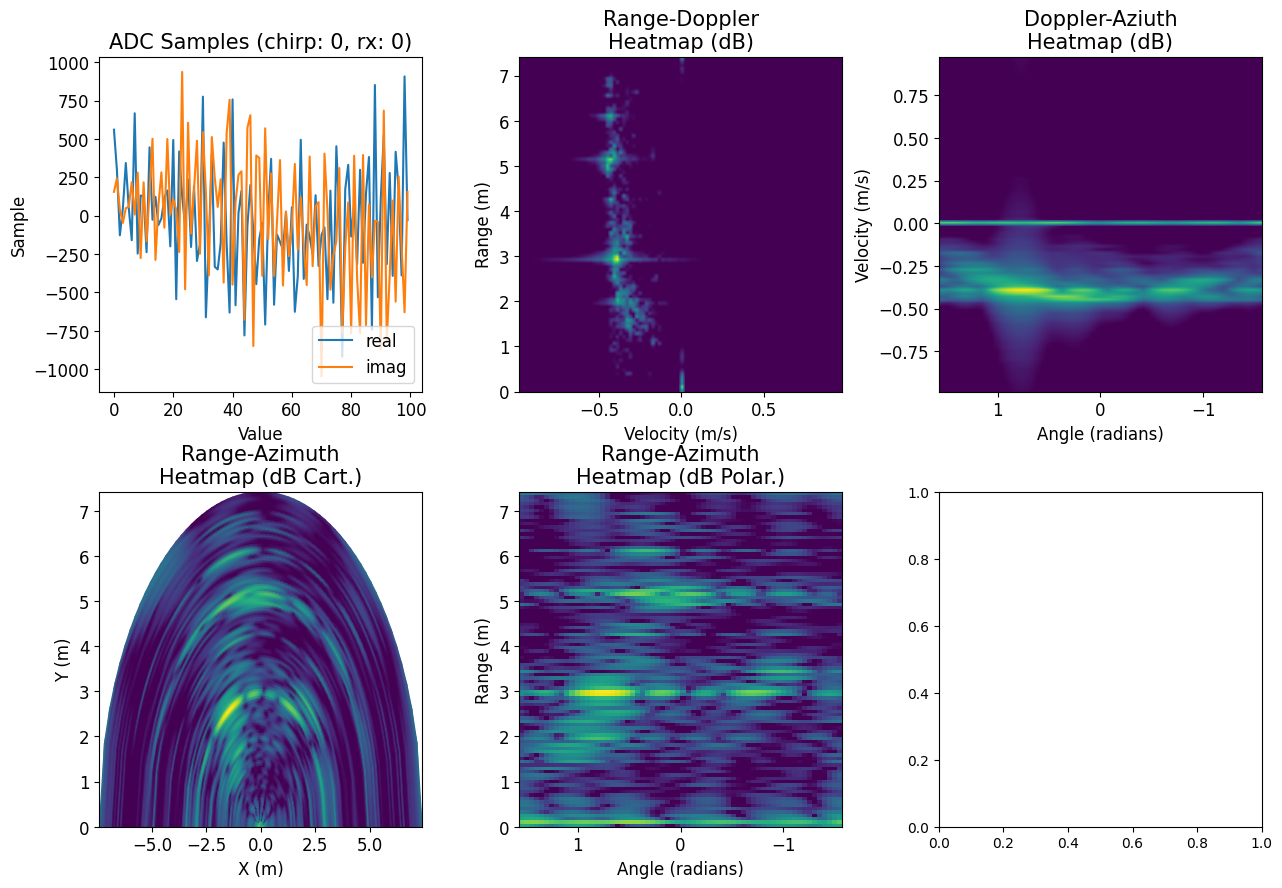

In [11]:
#for getting access to the adc cube
adc_cube = dataset.get_radar_data(idx=200)

adc_cube = virtual_array_reformatter.process(adc_cube)

#for computing the raw responses
rng_az_resp = range_az_processor.process(adc_cube=adc_cube,chirp_idx=0)
rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)


#for generating a compilation of plots
fig,axs=plt.subplots(2,3, figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    range_doppler_processor=range_doppler_processor,
    range_azimuth_processor=range_az_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    convert_to_dB=True,
    cmap="viridis",
    chirp_idx=0,
    rx_antenna_idx=0,
    axs=axs,
    show=True
)

  0%|          | 0/613 [00:00<?, ?it/s]

100%|██████████| 613/613 [00:41<00:00, 14.94it/s]


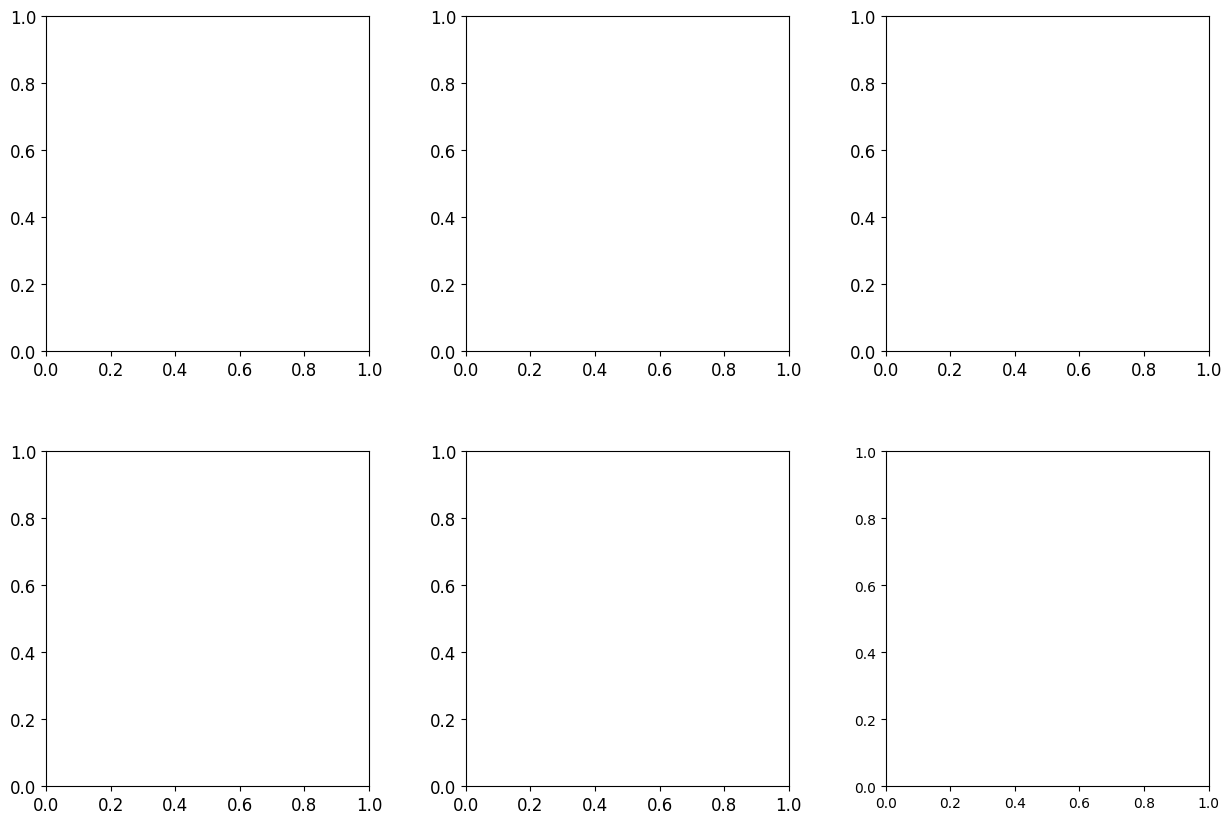

In [6]:
#generate the movie - initialize the figure
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))

#generate the movie frames
movie_generator.generate_movie_frames(
    chirp_idx=0,
    rx_antenna_idx=0,
    cmap="viridis",
    convert_to_dB=True
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_mmwave_processing.mp4".format(dataset_name),fps=fps)